# Packages

In [1]:
import GRN
import GRNCreationUtils
from utils import *
from genesGroup import subgraph3N
import pandas as pd
import networkx as nx
import matplotlib as plt

# Functions

In [ ]:
import networkx as nx
import itertools
from collections import Counter
from networkx.algorithms.isomorphism import DiGraphMatcher

def generate_motif_templates():
    """Returns a dictionary of canonical 3-node motif templates."""
    templates = {}

    def add_motif(name, edges):
        G = nx.DiGraph()
        G.add_edges_from(edges)
        templates[name] = G

    # Basic motif types (based on Alon 2002 classification)
    add_motif("Fan-In", [(1, 0), (2, 0)])
    add_motif("Fan-Out", [(0, 1), (0, 2)])
    add_motif("Cascade", [(0, 1), (1, 2)])
    add_motif("FFL", [(0, 1), (1, 2), (0, 2)])
    add_motif("FBL", [(0, 1), (1, 2), (2, 0)])
    add_motif("Bi-Mutual", [(0, 1), (1, 0), (1, 2), (2, 1)])
    add_motif("Clique", [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)])
    # Add more motifs if needed

    return templates


def classify_subgraph(subG, motif_templates):
    """Matches a 3-node subgraph to a motif type using isomorphism."""
    for name, motifG in motif_templates.items():
        matcher = DiGraphMatcher(subG, motifG)
        if matcher.is_isomorphic():
            return name
    return "Other"


def count_motifs(G):
    """
    Enumerates and classifies all 3-node subgraphs in a directed graph.
    
    Returns:
        motif_counts (Counter): motif type -> count
    """
    motif_templates = generate_motif_templates()
    motif_counts = Counter()
    
    for nodes in itertools.combinations(G.nodes, 3):
        subG = G.subgraph(nodes).copy()
        if nx.is_weakly_connected(subG):  # Optional: only count connected
            motif_type = classify_subgraph(subG, motif_templates)
            motif_counts[motif_type] += 1

    return motif_counts


def randomize_graph(G, n_swaps=1000, seed=None):
    """
    Returns a randomized version of the graph preserving in/out-degree distribution.
    Uses the Maslov-Sneppen edge-rewiring algorithm.
    """
    G_rand = G.copy()
    nx.double_edge_swap(G_rand, n_swaps=n_swaps, max_tries=n_swaps * 10, seed=seed)
    return G_rand

# Load the adjacency matrix as binary
def adj_mx_binary(adj_mx):
    binary_adj_mx = adj_mx.copy()
    binary_adj_mx[binary_adj_mx!=0] = 1.
    return binary_adj_mx

import networkx as nx
import numpy as np
import random as rd

# --- Direction assignment function (star-based) ---
def adjacenteDiMatriceStaredFromGraph(G: nx.Graph,
                                      autoRG: float,
                                      duoRG: float) -> nx.DiGraph:
    """
    Converts an undirected graph into a directed graph
    using a 'star' strategy: the highest-degree node is treated as a hub,
    and edges are oriented outward (with optional bidirectionality and self-loops).
    """
    DiG = nx.DiGraph()
    DiG.add_nodes_from(G)

    # Find the hub node (highest degree)
    degree_dict = dict(G.degree())
    motherNode = max(degree_dict, key=degree_dict.get)
    print(f"Hub node selected for directionality: {motherNode}")

    cache = set()
    distance = nx.single_source_shortest_path_length(G, motherNode)

    for nodeA in distance:
        for nodeB in G[nodeA]:
            edge = (nodeA, nodeB)
            if edge not in cache:
                cache.add(edge)
                cache.add(edge[::-1])
                rdNumber = rd.random()
                if rdNumber < duoRG:
                    DiG.add_edges_from([(nodeA, nodeB), (nodeB, nodeA)])
                else:
                    if distance[nodeA] <= distance[nodeB]:
                        DiG.add_edge(nodeA, nodeB)
                    else:
                        DiG.add_edge(nodeB, nodeA)
        if rd.random() < autoRG:
            DiG.add_edge(nodeA, nodeA)

    return DiG

# --- Connect components probabilistically by degree ---
def connect_components_by_degree(G, hub_bias=1.0):
    """
    Connects disconnected components by adding edges between them.
    Nodes are chosen with probability proportional to (degree ** hub_bias).
    """
    added_edges = 0
    while not nx.is_connected(G):
        components = list(nx.connected_components(G))
        compA, compB = components[0], components[1]

        degrees_A = np.array([G.degree(n) for n in compA])
        degrees_B = np.array([G.degree(n) for n in compB])

        # Amplify hub preference
        degrees_A = (degrees_A + 1e-3) ** hub_bias
        degrees_B = (degrees_B + 1e-3) ** hub_bias

        prob_A = degrees_A / degrees_A.sum()
        prob_B = degrees_B / degrees_B.sum()

        nodeA = np.random.choice(list(compA), p=prob_A)
        nodeB = np.random.choice(list(compB), p=prob_B)

        G.add_edge(nodeA, nodeB)
        added_edges += 1
        print(f"Connected node {nodeA} (deg={G.degree(nodeA)}) with {nodeB} (deg={G.degree(nodeB)})")

    print(f"Graph is now connected (added {added_edges} edges).")
    return G

# --- LFR generation with retry loop ---
def safe_LFR_benchmark(max_retries=10, **kwargs):
    attempt = 0
    while True:
        try:
            attempt += 1
            G = nx.generators.community.LFR_benchmark_graph(**kwargs)
            print(f"Successfully generated LFR graph on attempt {attempt}.")
            return G, attempt
        except nx.ExceededMaxIterations:
            print(f"Generation failed on attempt {attempt}, retrying...")
            if attempt >= max_retries:
                raise RuntimeError(f"Exceeded max retries ({max_retries}). LFR generation failed.")

# E.coli size equivalent network: 1525 genes

## Generate graph

In [16]:
# --- MAIN SCRIPT ---

# Define your parameters here
LFR_params = dict(
    n=1525,
    tau1=2.5,
    tau2=2.162,
    mu=0.1,
    average_degree=2.5,
    min_community=10,
    seed=None  # random seed each time for variability
)

# Generate LFR graph with retry loop
G_lfr, attempts = safe_LFR_benchmark(**LFR_params)

# Connect components if needed (with strong hub preference)
if not nx.is_connected(G_lfr):
    G_lfr = connect_components_by_degree(G_lfr, hub_bias=3.0)  # <<<< amplify hub bias here
else:
    print("Graph was already connected.")

# Apply direction assignment
G_lfr_directed = adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0,   # self-loop probability
    duoRG=0.05    # bidirectional edge probability
)

print(f"Finished! LFR graph generated in {attempts} attempt(s) and directed graph created.")

⚠️ Generation failed on attempt 1, retrying...
✅ Successfully generated LFR graph on attempt 2.
Connected node 0 (deg=3) with 1 (deg=2)
Connected node 1 (deg=3) with 2 (deg=5)
Connected node 0 (deg=4) with 1446 (deg=108)
Connected node 1446 (deg=109) with 4 (deg=4)
Connected node 1357 (deg=79) with 6 (deg=3)
Connected node 1494 (deg=45) with 9 (deg=3)
Connected node 1357 (deg=80) with 930 (deg=5)
Connected node 1198 (deg=100) with 604 (deg=4)
Connected node 1446 (deg=110) with 18 (deg=4)
Connected node 1446 (deg=111) with 133 (deg=17)
Connected node 1198 (deg=101) with 431 (deg=2)
Connected node 1198 (deg=102) with 239 (deg=9)
Connected node 1446 (deg=112) with 390 (deg=2)
Connected node 1198 (deg=103) with 118 (deg=6)
Connected node 1198 (deg=104) with 1227 (deg=4)
Connected node 1446 (deg=113) with 1338 (deg=5)
Connected node 1494 (deg=46) with 1196 (deg=3)
Connected node 1198 (deg=105) with 1069 (deg=2)
Connected node 1446 (deg=114) with 72 (deg=5)
Connected node 1446 (deg=115) with

## Motif analysis

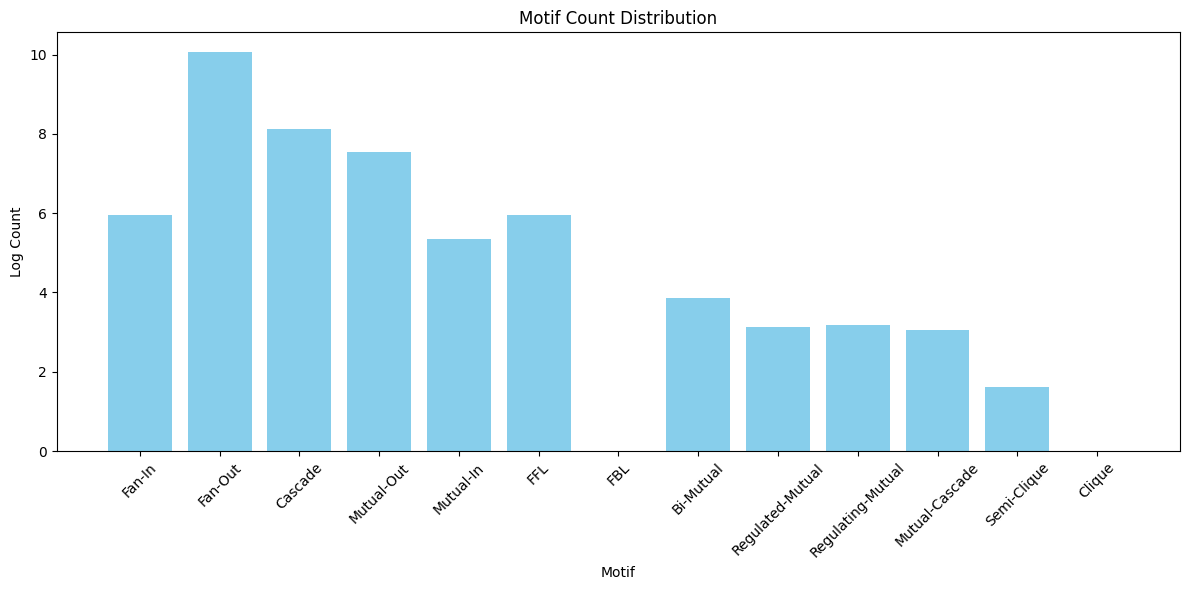

In [17]:
lfr_motifs = subgraph3N(G_lfr_directed)
motifs_count=get_all_motifs_count(lfr_motifs)

# Plot the motifs count
plot_motifs_count(motifs_count)

## Degree Analysis

The graph has been loaded as directed graph.
Plotting the graph...
Computing the degree distribution...
Plotting the scale free verification...
Fitting the power law distribution to the degree distribution...


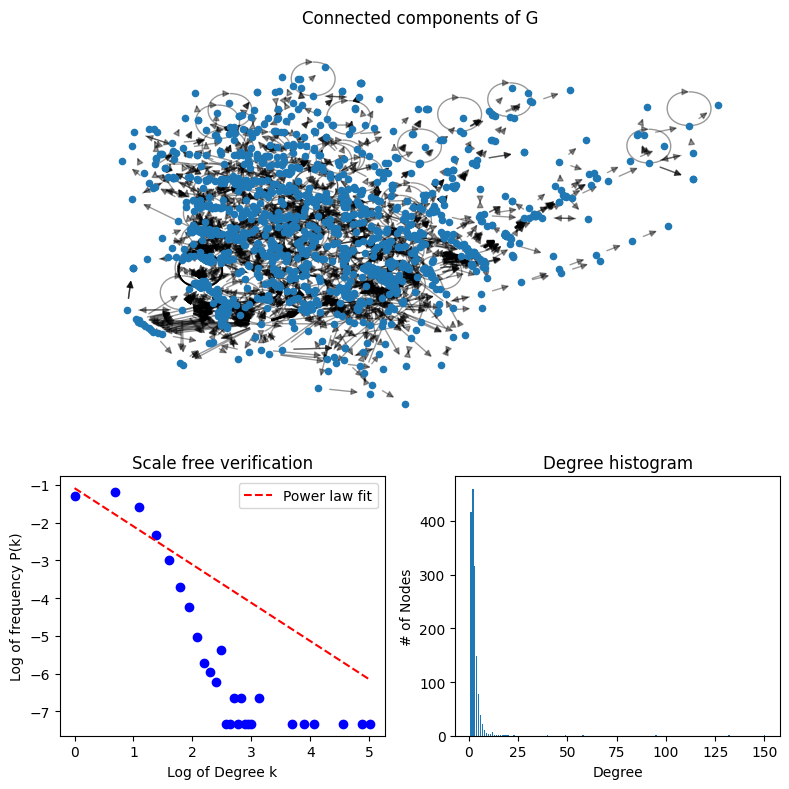

Graph strongly connected: False
Graph weakly connected: True
Modularity of the graph: 0.8888316522731508
Fitted power law parameters: a = 0.34, b = -1.01


In [18]:
# Plot the degree distribution
plot_grn_degree(nx.adjacency_matrix(G_lfr_directed), plot_network=True)